# Arm Reacher with Continuous Control

---

teach two DRL agents to play tennis in the [Unity Tennis environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis). 

---

You can download the environment matching your operation system from one of the following links:
* Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip)
* Mac OSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis.app.zip)
* Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86.zip)
* Windows (64-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86_64.zip)




## 1. Start the Environment

If necessary install following packages: **matplotlib**, **numpy**, **torch**, **unityagents**.


If needed uncoment the following cell and install **matplotlib**

In [1]:
import sys


# !{sys.executable} -m pip install matplotlib

If needed uncoment the following cell and install numpy

In [2]:
# !{sys.executable} -m pip install numpy

If needed uncoment the following cell and install torch. We will build the deep Q-Networks using torch.

In [3]:
#!{sys.executable} -m pip install torch

If needed uncoment the following cell and install unityagents. This package is needed to run the downloaded Unity Environment.

In [4]:
#!{sys.executable} -m pip install unityagents

Import the packages.

In [5]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment

from agent import Agent, Brain

seed = 123

Next, we will start the environment!

Before running the code cell below, change the `unityEnvPath` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`



In [6]:
unityEnvPath = 'path/to/Tennis/Executable/...'

env = UnityEnvironment(file_name=unityEnvPath,no_graphics=True,seed=seed)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


## 2. Examine the State and Action Spaces

Before starting with the training let's examine the environment.

The **state space** is `24` dimensional. There are `8` parameters corresponding to `position and velocity`  of the ball and racket whereby each agent receives its own, local observation.    
The **actions** are `2` corresponding to the movement of the racket `up-down` and `right-left`.  Every entry in the action vector must be a number between `-1` and `1`.

A **reward** of `+0.1` is provided if an agent hits the ball over the net. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a **negative reward** of `-0.01`. 


The **environment is considered solved**, when an average score of +0.5  (over 100 episodes) is reached.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
nrAgents = len(env_info.agents)
print('Number of agents:', nrAgents)

# number of actions
actionSize = brain.vector_action_space_size
print('Number of actions:', actionSize)

# examine the state space 
state = env_info.vector_observations[0]
stateSize = len(state)
print('States have length:', stateSize)
print('States look like:\n', state)


Number of agents: 2
Number of actions: 2
States have length: 24
States look like:
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.51024199 -1.5
 -0.          0.          6.80061245  6.         -0.          0.        ]


## 3. Train your agents

The goal of each agent is to keep the ball in play. 

This is a **cooperative game**. The reward of a given agent depends also on the skill of the other agent and the rewards of both agents grow the longer the ball is in play. 

To solve the environment we use the method of **Multi Agent Deep Deterministic Policy Gradients (MADDPG)**. The algorithm is implemented in the `Brain` class.  



Now we can define the training function: 

In [9]:

def trainAgents(env,agents,n_episodes=10000, max_t=1000, print_every=100, learn=True):
   
    solutionAverage = -np.Inf

    last100Scores = deque(maxlen=100)
    allScores = []                                         
    allAvgScores = []
    
    maxScore = -np.Inf
    totalMax = -np.Inf
    
    
    nrAgents = len(agents)
    actions = np.zeros((nrAgents,agents[0].brain.actionSize))
    
    
    for i_episode in range(1, n_episodes+1):
       
       
        # Per episode we have to reset the environment.
        env_info = env.reset(train_mode=learn)[brain_name]
        # Get the initial state.
        states = env_info.vector_observations        
        
        # reset each agent (important for time dependent noise classes)
        for agentNr in range(nrAgents):
            agents[agentNr].reset() 
            
        score = 0
        for t in range(max_t):
            
            # get the actions for each of the agents
            actions = np.zeros((nrAgents,actionSize))
            for agentNr in range(nrAgents):
                actions[agentNr] = agents[agentNr].act(states[agentNr])
           
            env_info = env.step(actions)[brain_name]
            # Obtain the next state.
            next_states = env_info.vector_observations
            # Get the reward.
            rewards = env_info.rewards
            # Get the done status.
            dones = env_info.local_done
           
            # performe a step for each of the agents
            for agentNr in range(nrAgents):
                agents[agentNr].step(states[agentNr], actions[agentNr], rewards[agentNr], next_states[agentNr], dones[agentNr])
            
            
            states = next_states
            score += np.max(rewards)                            # sets scores to cumulative rewards

            if np.any(dones):                                   # if done, break
                break

        last100Scores.append(np.max(score))
        avgScore = np.mean(last100Scores)
        
        allScores.append(np.max(score))
        allAvgScores.append(avgScore)

        maxScore = max(maxScore,score)  
        totalMax = max(maxScore,totalMax)  

        print('\rEpisode {}\tMean: {:.2f}\tscore: {:.2f}'
                  .format(i_episode, avgScore, np.max(score)), end="")
        
        if i_episode % print_every == 0:                        # check to print via modulus
            
            auxMean = 'mean: {:.3f}'.format(avgScore)
            auxLastMax = 'last max: {:.3f}'.format(maxScore)
            auxTotalMax = 'total max: {:.3f}'.format(totalMax)
            print('\n\n---> ','\t',auxMean,'\t',auxLastMax,'\t',auxTotalMax,'\n')
            maxScore = -100

        if avgScore >= 0.5:           # print and break when average score above defined
            
            if solutionAverage == -np.Inf:
                print('\n\n\n================================================================================')
                print("\r\rEnviroment solved after {i_episode} episodes with an avg_score of {avg:.2f}\r"                      
                      .format(i_episode=i_episode, avg=avgScore),end='\n')
                print('================================================================================\n\n\n')
                print('\n\n... continue learning for 100 more episodes ...\n\n')
                solved_plus100 = i_episode + 100
                

            if solutionAverage < avgScore:
                solutionAverage = avgScore
                # save models
                torch.save(agents[0].brain.actorLocal.state_dict(), 'checkpoint_actor.pth')
                torch.save(agents[0].brain.criticLocal.state_dict(), 'checkpoint_critic.pth')
                

            if i_episode > solved_plus100:
                break

    return allScores, allAvgScores

In [10]:
def plotScores(scores,title='',meanOver = 100, threshold = 0.5):
    """
    Plot the scores
    """
    
    if len(scores)<meanOver:
        meanOver = len(scores)
    
    scores = np.array(scores)
    yLimMin = min(scores) * 1.05 - 1.e-2
    yLimMax = max(scores) * 1.05
    
    runMean = np.convolve(scores, np.ones((meanOver,))/meanOver,mode='valid')[1:]

    mean13 = np.argwhere(runMean>threshold) + meanOver + 1
    score13 = np.argwhere(scores>threshold)
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.plot(np.arange(meanOver,len(scores)), runMean,color = 'r')
    
    plt.plot([0, len(scores)],[threshold,threshold],'g')
    plt.plot([mean13[0],mean13[0]],[-5,yLimMax],'g')
    plt.text(mean13[0],-(yLimMax-yLimMin)*1.e-1 ,str(mean13[0]),color = 'g')
    
    #plt.scatter(score13,scores[score13],color='r')
    
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.xlim([0,len(scores)])
    plt.ylim([yLimMin,yLimMax])
    return plt





To run the training method we need two agents, playing simultaniously. For the MADDPG method both agents have to share the same actor, respectively critic, networks and the same experience memory. In our cas this means that both agents have to share the same `Brain` instance.

Remark that we are not using the soft update of the target network but a hard update. i.e. the target network is completely overridden after a given number of update steps.


### Using Replay-Buffer without Prioritizing Experience

We first create an instance of the `Brain` class **without using prioritized memory**. 



In [11]:
brain = Brain( stateSize=stateSize, actionSize=actionSize,
            
            actorHiddenLayers=[256,64,32], 
            actorBatchNormAfterLayers=None,#[0,1,2],
            
            criticHiddenLayers=[256,128,16], 
            criticBatchNormAfterLayers=None,#[0,1,2],
            criticAttachActionToLayer = 1,
            
            gamma = 0.99,
            actorLearningRate = 5e-4,   
            criticLearningRate = 5e-4,   
            
            actorSoftHardUpdatePace = 10,  
            criticSoftHardUpdatePace = 10,  
            
            dnnUpdatePace = 2, 
            bufferSize = int(1e6),
            batchSize = 128,
            batchEpochs = 2,
            weightDecay = 0.0,
            
            usePrioritizedMemory = False,   # <--------------------------
            
            seed = seed)
 
# create an instance of the Agent class for each player, whereby they all share the same brain
agents = []
for agentNr in range(nrAgents):
    agents.append(Agent(brain, seed = seed, noiseScale = 0.2))


Check the network architecture

In [12]:
print('-----------ACTOR NETWORK-----------')
print(agents[0].brain.actorLocal)
print('\n')
print('-----------CRITIC NETWORK-----------')
print(agents[0].brain.criticLocal)

-----------ACTOR NETWORK-----------
Actor(
  (network): ModuleList(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (outLayer): Linear(in_features=32, out_features=2, bias=True)
)


-----------CRITIC NETWORK-----------
Critic(
  (network): ModuleList(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): Linear(in_features=258, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=16, bias=True)
  )
  (outLayer): Linear(in_features=16, out_features=1, bias=True)
)


In [13]:
scores, _ = trainAgents(env,agents)

Episode 100	Mean: 0.00	score: 0.00

--->  	 mean: 0.001 	 last max: 0.100 	 total max: 0.100 

Episode 200	Mean: 0.00	score: 0.00

--->  	 mean: 0.000 	 last max: 0.000 	 total max: 0.100 

Episode 300	Mean: 0.06	score: 0.10

--->  	 mean: 0.058 	 last max: 0.600 	 total max: 0.600 

Episode 400	Mean: 0.27	score: 0.90

--->  	 mean: 0.269 	 last max: 2.400 	 total max: 2.400 

Episode 452	Mean: 0.50	score: 0.50


Enviroment solved after 452 episodes with an avg_score of 0.50





... continue learning for 100 more episodes ...


Episode 500	Mean: 0.77	score: 0.40

--->  	 mean: 0.773 	 last max: 5.100 	 total max: 5.100 

Episode 553	Mean: 0.90	score: 1.60

<module 'matplotlib.pyplot' from '/home/ptrtmv/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

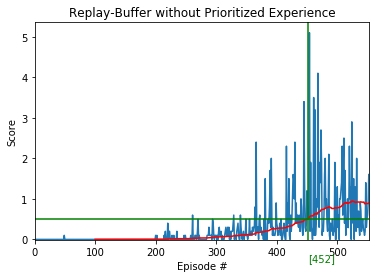

In [14]:
plotScores(scores,title='Replay-Buffer without Prioritized Experience')

### Using Prioritized Experience Replay

Now we can create an instance of the `Brain` class **using prioritized memory**. 

The idea behind prioritized experince is that we prefer transitions that do not fit well to our current estimate of the Q function, because these are the transitions that we can learn most from. 


In [15]:
brain = Brain( stateSize=stateSize, actionSize=actionSize,
            
            actorHiddenLayers=[256,64,32], 
            actorBatchNormAfterLayers=None,#[0,1,2],
            
            criticHiddenLayers=[256,128,16], 
            criticBatchNormAfterLayers=None,#[0,1,2],
            criticAttachActionToLayer = 1,
            
            gamma = 0.99,
            actorLearningRate = 5e-4,   
            criticLearningRate = 5e-4,   
            
            actorSoftHardUpdatePace = 10,  
            criticSoftHardUpdatePace = 10,  
            
            dnnUpdatePace = 2, 
            bufferSize = int(1e6),
            batchSize = 128,
            batchEpochs = 2,
            weightDecay = 0.0,
            
            usePrioritizedMemory = True,   # <--------------------------
            
            seed = seed)
 
# create an instance of the Agent class for each player, whereby they all share the same brain
agents = []
for agentNr in range(nrAgents):
    agents.append(Agent(brain, seed = seed, noiseScale = 0.2))


We use the same network architecture as above with the same parameters.

In [16]:
print('-----------ACTOR NETWORK-----------')
print(agents[0].brain.actorLocal)
print('\n')
print('-----------CRITIC NETWORK-----------')
print(agents[0].brain.criticLocal)

-----------ACTOR NETWORK-----------
Actor(
  (network): ModuleList(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (outLayer): Linear(in_features=32, out_features=2, bias=True)
)


-----------CRITIC NETWORK-----------
Critic(
  (network): ModuleList(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): Linear(in_features=258, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=16, bias=True)
  )
  (outLayer): Linear(in_features=16, out_features=1, bias=True)
)


Start the trainig

In [17]:
scoresPrioritized, _ = trainAgents(env,agents)

Episode 100	Mean: 0.03	score: 0.10

--->  	 mean: 0.031 	 last max: 0.500 	 total max: 0.500 

Episode 200	Mean: 0.43	score: 0.00

--->  	 mean: 0.428 	 last max: 2.100 	 total max: 2.100 

Episode 212	Mean: 0.50	score: 1.90


Enviroment solved after 212 episodes with an avg_score of 0.50





... continue learning for 100 more episodes ...


Episode 300	Mean: 0.99	score: 0.00

--->  	 mean: 0.988 	 last max: 5.200 	 total max: 5.200 

Episode 313	Mean: 0.97	score: 1.70

<module 'matplotlib.pyplot' from '/home/ptrtmv/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

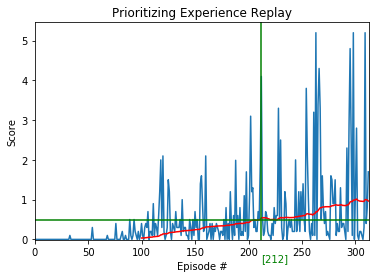

In [18]:
plotScores(scoresPrioritized,title='Prioritizing Experience Replay')

Let us compare the plots of the trainings with and without prioritized learning

<module 'matplotlib.pyplot' from '/home/ptrtmv/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

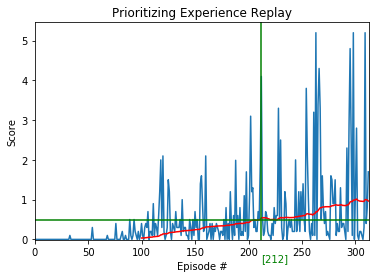

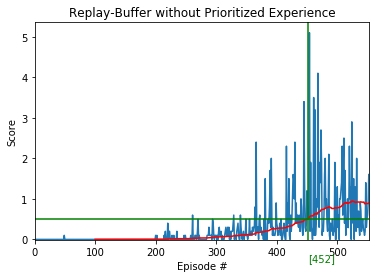

In [19]:
plotScores(scoresPrioritized,title='Prioritizing Experience Replay')
plotScores(scores,title='Replay-Buffer without Prioritized Experience')

At this poin we should say that, in general, both methods converge and are able to find a solution. However both methods strongly depend on the initial conditions (i.e. choice of the seed for instance) and the number of episodes for solving the environment varies strongly. 

Our observation is that **more often than not the MADDPG with prioritized learning performs better**. 

### 5. Watch a Smart Agent!

Now we can load the trained weights from the files and watch the performance of the trained agent.

In [20]:
brain.actorLocal.load_state_dict(torch.load('checkpoint_actor.pth'))
brain.criticLocal.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]   # reset the environment
states = env_info.vector_observations                # get the current state(s)
scores = np.zeros(nrAgents)                        # initialize the score(s)



while True:
   
    # get the actions for each of the agents
    actions = np.zeros((nrAgents,actionSize))
    for agentNr in range(nrAgents):
        actions[agentNr] = agents[agentNr].act(states[agentNr])
           
    env_info = env.step(actions)[brain_name]
    # Obtain the next state.
    next_states = env_info.vector_observations
    # Get the reward.
    rewards = env_info.rewards
    # Get the done status.
    dones = env_info.local_done

    scores += rewards                                # update the score(s)
    states = next_states                             # roll over the state to next time step
    if np.any(dones):                                # exit loop if episode is finished
        break

print("Score: {:.2f}".format(max(scores)))                 

Score: 0.50


Close the environment

In [21]:
env.close()